<h1 style="text-align: center; color : #f31567; font-family: Comic Sans MS;">
    Analytic Model for Light Yield Estimation version 2.0
<!-- <span style= 'color : #f31567'> Analytic Model for Light Yield Estimation version 2.0 </span>  -->
<!-- <span style= 'color : #f31567'> Analytic Model for Estimating Light Collection Efficiency Version 2.0 </span>  -->
</h1>
<hr>
<br>
<p style='color : #9932CC;  font-size: 16pt; font-family: Comic Sans MS;'>
    Story so far.. :
<span style= 'color : silver; text-align: center;font-family: Comic Sans MS;'> This notebook is written to implement Segreto model.
    <ol style = 'font-family: consolas;'>
       <li> It has the provision to include the Rayleigh scattering and absorption. ✅</li> 
       <li> renamed few variables to be compliant with Segreto's paper. ✅</li>
       <li> I will add additional terms later for the configuration where even SiPM is covered with WLS. ✅</li>
       <li> default value Q_vis = 1</li>
        <li> default value Q_vuv = 1</li>
        <li> default value $\epsilon_{wls} = 1 $</li>
        <li> default value SY=40</li>
        <li> throughout this notebook the unit of length is m</li>
        <li> we have a serious problem when f_sen =1, LY =0 which shouldn't be the case. Should we include SiPM PDE in VUV range 
            <span style = 'color: orange'> [awaiting Marcin's response] </span> </li>
        <li> check out why Segreto has a weird way of extrapolating his model when number of SiPM > 1 </li>
        <li> what is WLS's reflectance to VUV</li>
        <li> We are not accounting for absorption of Visible light in WLS coated over SiPM, obviously without ESR its reflectance will drop and it will allow visible photon to pass more freely but absorption and reflectance could still be significant. To fix this we should use reflectance values of WLS coupled with SiPM.<p style = 'color: orange;'> Ask Marcin. </p></li>
        <li> Confirm TPC and Titanium Vessel dimensions <p style = 'color: orange;'> Ask Marcin. </p></li>
        <li> </li>
        <li> </li>
        <li> </li>
        <li> </li>
    </ol>

</span> 
<!-- </p> -->

<span style = 'color:tomato; text-align: left; font-family: Comic Sans MS;'> 
    Relevant Documentation: 
<a href="https://www.overleaf.com/read/vpkvkgpfqwst">https://www.overleaf.com/read/vpkvkgpfqwst</a>
    
<!-- 
$$
LCE = \frac{X}{1-(s+w)} 
$$
<br>
$$ LCE = \frac{f_{sen}FF_{sys}(1-R)}{1-( f_{sen}R + (1-f_{sen})R_{wall} )} $$ -->
<br>
    Relevant Documentations: 
<a href="https://arxiv.org/pdf/1110.6370.pdf">Segreto 2012</a>    

<br>
    Research Notes: 
<a href="https://docs.google.com/document/d/1k-8OMUld0fGFGO-Om6wp_pJkQwOL-QxgrfYoKsZIPF4/edit">Google Docs link </a>
    
</span>
</p>

In [1]:
from os import path
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
%matplotlib inline
# %matplotlib qt

In [2]:
%%html
<!--- html styling for Jupyter Dark Theme---!>
<style>
.CodeMirror-focused .CodeMirror-selected { background: none; }
.CodeMirror-focused .CodeMirror-selectedtext { background: #FF0088; } 
.CodeMirror-selected { background:  grey; }
</style>
<!--- greenish #00FF88 ; pinkish #FF0088 ; turquoise---!>

<h2 style = 'color:#66AAEE; font-size: 20pt; text-align: center;'>
    Data loading & Pre-processing
</h2>

<p style ='color: silver; font-size: 14pt'> project directory is defined in the following cell; it will remain same through out the notebook.
</p>
<p style ='color: silver; font-size: 14pt'>PS:  The preprocessing is different for each file depending on its data structure.
</p>

<h3 > ✏ <span style = 'color: #7bc5ef; '> Project Directory </span>
</h3>

In [3]:
### define project directory
project_dir = r'C:\Users\sarth\projects\LY_Analytic_Model'; 

<h3 style = 'text-align: left;  color:magenta; font-family: courier prime; font-size:16pt;'>
     SiPM Reflectance data
</h3>
<!-- <p>
    SiPM Reflectance .dat file provided by Cenk
    <br>
    <span style = 'color: #FF6611; font-size: 18px'> Note: </span> 
    SiPM Reflectance is multiplied by 0.91 to take care of the effect of antireflective coating in Liquid Argon chamber (needs further investigtation)
</p> -->

In [4]:
R_SiPM_df = pd.read_csv(path.join(project_dir, 'Data','sipm_hr1_processed.txt'), sep = '\t')  ## 'Data' is the name of the folder containing Data files
R_SiPM = R_SiPM_df.copy()
R_SiPM['R'] = [int(value)/100 for value in R_SiPM_df['R']]

## cenk's data files for darkside veto are given below

# cenk_SiPM_R_df = pd.read_csv(path.join(project_dir, 'Data','SiPM_ref.csv'), sep = ',')
# # cenk_SiPM_R_values = cenk_SiPM_R_vector.copy()
# # cenk_R_SiPM_values['R'] = [int(value)/100 for value in cenk_R_SiPM_vector['R']]
# cenk_SiPM_R_df2 = cenk_SiPM_R_df.copy()
# cenk_SiPM_R_df2['LAr_equivalent_Reflectance'] = cenk_SiPM_R_df2['R']*0.91 

# ### Note: SiPM is coated with an unknown anti-reflection coating
# ### 0.91 : To get the unknown reflectivity of SiPM in Liquid Argon. Since SiPM is also coated with an anti reflection coating, getting the equivalent 
# ### reflectance is not straight forward. 0.91 is based on an educated guess.

# cenk_SiPM_R_df2['wavelength'] = 1239.847/cenk_SiPM_R_df2['E'] # Eneergy unit eV wavlength Unit: nm
# # SiPM_ref.dat
# # cenk_SiPM_R_df3 = cenk_SiPM_R_df2.sort_values(by = 'wavelength')

In [5]:
# cenk_SiPM_R_df2.head()

In [6]:
# plt.figure()
# plt.plot(cenk_SiPM_R_df2['wavelength'], cenk_SiPM_R_df2['R'])
# plt.plot(SiPM_R_values['Wavelength'], SiPM_R_values['R'])

<h3 style = 'text-align: left;  color:magenta; font-family: courier prime; font-size:16pt;'> 
    SiPM PDE data
</h3>
<p>
    Caustion : when using FBK PDE values, normalize with 40/52.77
    Marcin: normalize LFoundry values as well. After normalizaton maximum value should be  40.
</p>

In [7]:
### FBK Values sent by cenk
# photon_wavelength = [285.87, 301.14, 320.99, 340.83, 365.26, 380.53, 391.22, 400.38, 411.06, 420.22, 435.49, 449.23, 464.50, 499.61, 588.16, 698.09]
# PDE_vector = [18.39, 37.24, 41.87, 42.43, 45.03, 48.12, 52.72, 52.75, 52.77, 52.29, 48.77, 46.26, 40.71, 38.76, 28.82, 18.93] # %age values
# PDE_normalized_vector = []
### Normalizing PDE values in FBK data as instructed by Cenk
# PDE_normalized_vector = [value*40/max(PDE_vector) for value in PDE_vector]
## PDE_normalized_vector
# norm_PDE_values = [value/100 for value in PDE_normalized_vector]

### LFoundry PDE Values sent by Cenk
photon_wavelength = [365.39, 390.34, 399.89, 409.98, 420.06, 434.93, 450.32, 500.21, 525.16, 545.33, 590.98, 630.25, 700.32]
PDE_vector = [43.277, 51.892, 54.257, 52.399, 50.709, 46.993, 42.601, 36.014, 30.439, 28.581, 24.358, 20.473, 15.574]
# Normalization for PDE values 
norm_PDE_values = [value*40/(100* max(PDE_vector)) for value in PDE_vector]


frame = {'photon_wavelength':photon_wavelength, 'PDE_norm': norm_PDE_values}

PDE = pd.DataFrame(frame)

# max(PDE['PDE_norm'])

<h3 style = 'text-align: left;  color:magenta; font-family: courier prime; font-size:16pt;'>
   PEN Reflectance Data 
</h3>
<!-- <p>
<span style= 'color: red; font-size : 22px'>  Needs verification !!! 
</span>
</p> -->

In [8]:
## R_wall_PEN = 
PEN_photon_energy = [0.1, 2.067,2.175,2.214,2.255,2.340,2.385,2.431,2.436,2.531,2.583,2.638,2.696,2.725,2.756,2.787,2.818,
2.884,2.918,2.952,2.988,3.024,3.039,3.047,3.054,3.062,3.069,3.077,3.085,3.092,3.100,3.108,3.116,3.123,3.131,3.139,3.147,3.155,
3.163,3.171,3.179,3.188,3.196,3.204,3.212,3.221,3.263, 8.0] ## energy in eV

PEN_reflectance = [100.130, 100.130,99.995,99.856,99.681,99.659,99.569,99.351,99.306,99.018,98.652,98.415,98.283,
98.018,97.856,97.606,97.457,97.134,96.928,96.827,96.247,95.737,95.359,95.197,95.048,94.876,94.684,94.463,94.055,93.650,93.147,
92.562,91.812,90.904,89.807,88.506,86.957,85.242,83.156,80.678,77.811,74.615,71.004,67.089,62.924,58.670,20.000, 20.000] ## %age reflectance

# PEN_reflectance = [reflectance*0.98/100 for reflectance in PEN_reflectance] 
PEN_reflectance = [reflectance*0.98*0.994/100 for reflectance in PEN_reflectance] 

### Reflectance is multiplied by 0.98 and 0.994 for calibration purpose:
    ### 1. 0.98 is the reflectance of Basrium Sulphate used as the standard in photo spectrometer
    ### 2. The second factor is specific to 2PAC. 0.994 is the coverage fraction of Wavelength Shifting material (a small surface coverage is lost to holes, bolts etc in 2PAC)
### The calculation is very senstitive to Reflectance


photon_wavelength = []

for energy_value in PEN_photon_energy:
    wavelength_value = 1239.847/energy_value
    photon_wavelength.append(wavelength_value)

frame = {'photon_wavelength': photon_wavelength,
        'PEN_reflectance': PEN_reflectance}

R_Wall_PEN = pd.DataFrame(frame)

## reverse the order of wavelength smaller to bigger
R_Wall_PEN = R_Wall_PEN.iloc[::-1]

# R_Wall_PEN

<h3 style = 'text-align: left;  color:magenta; font-family: courier prime; font-size:16pt;'> PEN Emission Spectrum </h3>

In [9]:
# r_PEN = r'D:\D Downloads\Current_work\pen-tess.txt'
r_PEN = path.join(project_dir, 'Data', 'pen-tess.txt')
emission_spectrum_PEN = pd.read_csv(r_PEN, sep ='\t')

E_PEN = emission_spectrum_PEN.drop(['a','b','c'], axis=1)

# E_PEN

# normalize : divide by maximum value
E_PEN['efficiency'] = E_PEN['efficiency']/max(E_PEN['efficiency'] ) 

# remove negative values
E_PEN = E_PEN[E_PEN > 0].dropna()
# E_PEN['efficiency']
## What are the units of efficiency? Normalize PEN Spectrum ??
## Remove negative values?
## Need linear interpolation for everyuthing R, R_Wall, PDE and emission spectrum

<h3 style = 'text-align: left;  color:magenta; font-family: courier prime; font-size:16pt;'> TPB Reflectance data 
</h3>

In [10]:
TPB_photon_energy = [0.1, 2.067,2.175,2.214,2.255,2.340,2.385,2.431,2.436,2.531,2.583,2.638,2.696,2.725,2.756,2.787,2.818,2.884,2.918,2.952,2.988,3.024, 3.221,3.263, 8.0]
TPB_reflectance = [98.936,98.936,99.180,99.309,99.375,99.392,99.534,99.490,99.491,99.685,99.635,99.593,99.541,99.457,99.380,99.374,99.196,98.924,98.521,97.653,95.581,92.569,13.0,3.0,3.0]

photon_wavelength = []

# TPB_reflectance = [reflectance*0.98/100 for reflectance in TPB_reflectance]
TPB_reflectance = [reflectance*0.98*0.994/100 for reflectance in TPB_reflectance]

### Reflectance is multiplied by 0.98 and 0.994 for calibration purpose:
    ### 1. 0.98 is the reflectance of Basrium Sulphate used as the standard in photo spectrometer
    ### 2. The second factor is specific to 2PAC. 0.994 is the coverage fraction of Wavelength Shifting material (a small surface coverage is lost to holes, bolts etc in 2PAC)
### The calculation is very senstitive to Reflectance

for energy_value in TPB_photon_energy:
    wavelength_value = 1239.847/energy_value
    photon_wavelength.append(wavelength_value)

frame = {'photon_wavelength': photon_wavelength,
        'TPB_reflectance': TPB_reflectance}

R_Wall_TPB = pd.DataFrame(frame)

## reverse the order of wavelength smaller to bigger
R_Wall_TPB = R_Wall_TPB.iloc[::-1]

# R_Wall_TPB

<h3 style = 'text-align: left;  color:magenta; font-family: courier prime; font-size:16pt'> TPB Emission Spectrum </h3>

In [11]:
#### why do we have negative values?
#### Might need to clean data
## drop negative values
## normalize efficiency

# r_TPB = r'D:\D Downloads\Current_work\tpb-fran.txt'
r_TPB = path.join(project_dir, 'Data','tpb-fran.txt')
emission_spectrum_TPB = pd.read_csv(r_TPB, sep ='\t')

E_TPB = emission_spectrum_TPB.drop(['a','b','c','d'], axis=1)
# E_TPB

<p style = 'color:slate'> Click here to see a warning </p>
<!-- Warning: TPB data has negative values -->

In [12]:
# normalize : divide by maximum value
E_TPB['efficiency'] = E_TPB['efficiency']/max(E_TPB['efficiency'] ) 
# remove negative values
E_TPB = E_TPB[E_TPB > 0].dropna()

# E_TPB


<h3 style = 'color:deeppink'> Smoothing function </h3>

In [13]:
### variable name 'photon_wavelength' is NOT hard coded for all the data frames.
def make_smooth(data_frame_var):
    name_column_0 = data_frame_var.columns[0]
    name_column_1 = data_frame_var.columns[1]
    
    photon_wavelength = data_frame_var[name_column_0]
    physical_quantity = data_frame_var[name_column_1]
    
    interpol_func = interp1d(photon_wavelength , physical_quantity)
    return  interpol_func(wavelength_vector)

<h3> 
✏ <b style = "font-size:18pt; font-family: courier prime; color: #7bc5ef;"> Define Wavelength range </b>

</h3>
<br>
<p style = 'color:silver'>
    wavelength_vector is common throughout the notebook.
</p>

In [14]:
wavelength_vector = np.arange(366, 560, 0.5)  ### do we want to hard code wavelength range?

In [15]:
### call smoothing functions here
R_SiPM_smooth = make_smooth(R_SiPM)

R_Wall_PEN_smooth = make_smooth(R_Wall_PEN)

R_Wall_TPB_smooth = make_smooth(R_Wall_TPB)

PDE_smooth = make_smooth(PDE)

E_PEN_smooth = make_smooth(E_PEN)

E_TPB_smooth = make_smooth(E_TPB)   

<h2 style= 'text-align: center; font-size:24pt'>
    <span style  = 'color: gold'> Wavelength integrated LY with Absorbtion and Rayleigh Scattering effects</span>
</h2>

<h3 style = 'color: DeepPink '> calculating $Q$ factor
</h3>

<span style ='color:lime; font-size:14pt;' >
$$
Q = \frac{1- (1 - U_{RA}) \times \frac{\lambda_{eff}}{\lambda_{R}}}{U_{RA}}
$$
</span>

In [16]:
from sympy import Symbol, exp, integrate

x = Symbol('x')

## L_char is basically what L tilde is in segreto paper

## lambda_eff is basically lambda tilde in segreto paper

def calc_lambda_eff(lambda_abs, lambda_R):
    ''' Calculates effective lambda for Rayleigh scattering and Absorption.
    Unit of length: m
    '''
    return (lambda_R*lambda_abs)/(lambda_R + lambda_abs)

def P_func(L_char, lambda_eff):
    ''' 
    P_func: P(x) is the probability distribution of the distances that a photon would travel in absence of interactions (between two reflections or between a reflection and absorption/detection).
    The P_func can be changed later if it is felt that we need a different probability distribution function. 
    '''
    return 1/(L_char)

def calc_URA(L_char, lambda_eff, Prob_distr):
    return integrate( Prob_distr*exp(-x/lambda_eff), (x, 0, L_char))

def calc_Q( L_char,  lambda_abs, lambda_R):
    ''' 
    This function is used to compute Q factor for both visible and VUV photons.
    Note:
    We'll call calc_URA since URA is wavelength dependent. We'll also make a call to P_func for the same reason.
    '''
    lambda_eff = calc_lambda_eff(lambda_abs, lambda_R)
    
    Pdf = P_func(L_char, lambda_eff); # Probability distribution function
    
    URA_value = float(calc_URA(L_char, lambda_eff, Pdf));
    
    return (1-(1-URA_value)*lambda_eff/lambda_R)/(URA_value)

<h3 style = 'color:deeppink;'> Calculating characteristic length </h3>
<p style = 'color:lime; font-size:14pt'>
$$ L\_char = 6\times \frac{volome}{surface\_area}
$$
</p>

In [17]:
def calc_length(area, volume):
    return 6*volume/area

<h3 style = 'color:DeepPink;'>  Calculating $F $
</h3>

<span style = 'color : lime;  font-size:14pt;'>

$$ F( Q, f_{sen}FF_{sys}(1-R), f_{sen}R + (1-f_{sen} )R_{wall} ) = \frac{f_{sen}FF_{sys}(1-\color{Red}R)}{\color{Red}Q-( f_{sen}\color{Red}R + (1-f_{sen})\color{Red}{R_{wall}} )} $$

</span>

<span style = 'color : lime;  font-size:14pt;'>

$$ F(Q,X, s + w) = \frac{X}{Q-(s+w)} $$

</span>

In [18]:
def calc_F(R, R_wall, f_sen, FF_sys, Q_value):    
    '''
    R, R_wall are all wavelength dependent. Q_value is provided as an argument.
    '''
    return (f_sen*FF_sys*(1-R))/(Q_value - (f_sen*R + (1-f_sen)*R_wall) )

<h3 style = 'color: DeepPink '> Calculating Light Collection Efficiency, $LCE$
</h3>

<br>
<p style = 'color:lightgreen; font-size: 14pt'> When SiPM is not covered with WLS.
<span style = 'color:lime;  font-size:14pt;'> 
    $$
    LCE = \frac{(1-f_{sen}) \times \epsilon_{wls} \times \color{Red}{F(Q_{vis}, X, s+w)}}{Q_{VUV}}
    $$
</span>
</p>
<br>

<br>
<p style = 'color:lightgreen; font-size: 14pt'> When SiPM is covered with WLS.
    <br>
    In this case, R_SiPM will simply be the reflectance of WLS coupled with SiPM. 
    <br>
    Stack : WLS | SiPM  </p>
<span style = 'color:lime;  font-size:14pt;'> 
<br>
    $$
    LCE = \frac{0.5 \times (1-R) \times f_{sen} \times \epsilon_{wls} + (1-0.5 \times f_{sen}) \times \epsilon_{wls} \times \color{Red}{F(Q_{vis}, X, s+w)}}{Q_{VUV}}
    $$
</span>
<br>

In [19]:
def calc_LCE(R, R_wall, f_sen, FF_sys, wls_eff, Q_vuv=1, Q_vis=1, SiPM_covered = False):
    ''' calc_LCE requires Q_vis and Q_vuv values as arguments. Both are set at default value of 1.
    Though Absorption and Rayleigh scattering lengths will be dependent on wavelength,
    currently we don't have accurate meansurements of these values for different wavelengths.
    Hence we will be using an average value for entire visible spectrum and another value for VUV (remember VUV photon has a single wavelength).
    In case accurate values of absorption and scattering lengths become available I will need to modify the Q_vis accordingly.
    Side note: Q_vis and Q_vuv are provided as arguments to the function integrate_LY.
    New!!! calc_LCE has additional Arguement SiPM_covered. 
    Note by default LCE is calculated for the case when SiPM is not covered with WLS.
    '''
    if SiPM_covered == False:
        return (1-f_sen)*wls_eff*calc_F(R, R_wall, f_sen, FF_sys, Q_vis)/(Q_vuv)
    elif SiPM_covered == True:
        return (wls_eff/Q_vuv)*( (1-R)*f_sen/2 + (1-0.5*f_sen)*calc_F(R, R_wall, f_sen, FF_sys, Q_vis) )
    

<h3 style = 'color: DeepPink; text-align:center; font-size:24pt; '> 🍕 integrate Light Yield
</h3>
<!-- <p>
Previously known as Weighted Average of Light Yield 
</p> -->

<!-- <p> 
<span style = 'color : #5EA9E5;'> 
<br>
% $$
% integrate\_LY = \frac{\sum( [LY\_value(\color{red}{PDE(\lambda)}, f_{sen}, FF_{sys}, \color{red}{R(\lambda)}, \color{red}{R_{wall}(\lambda)}, \color{red}{Q(\lambda)}, \epsilon_{wls} ) ] * \color{red}{E_{wls}(\lambda)})}{\sum \color{red}{E_{wls}(\lambda)}}
% $$
</span>
<br>
<br>
<br>
</p> -->

<p> 
<span style = 'color : lime; font-size:14pt;'> 
<br>
<br>
$$
integrate\_LY = \frac{SY* \sum( [calc\_LCE(f_{sen}, FF_{sys}, \color{red}{R(\lambda)}, \color{red}{R_{wall}(\lambda)}, \color{red}{Q(\lambda)}, \epsilon_{wls}) ] * [ \color{red}{PDE(\lambda)} ] * [ \color{red}{E_{wls}(\lambda)} ] ) } {\sum \color{red}{E_{wls}(\lambda)}}
$$
</span>
<br>
<br>
<span style= ' font-size:14pt; text-align: left; color:lightgreen;'>
PS: <span style = 'color:red; '>Red </span>--> wavelength dependent
<br>
    $E_{wls}$ is the emission spectrum of wavelength shifter.
<br>
    $\epsilon_{wls}$ is the wavelength shifting efficiency. See variable wls_eff
</span>
</p>

In [20]:
# def integrate_LY(wavelength_range, WLS_emission_spectrum, PDE_smooth, R, R_wall, f_sen, FF_sys, SY=40): 
### think of a way so that we don't have to specify wavelength_vector from outside
def integrate_LY(wavelength_vector, WLS_emission_spectrum, PDE_smooth, R, R_wall, f_sen, FF_sys = 1, Q_vis = 1, Q_vuv = 1, wls_eff = 1.0, SY = 40, SiPM_covered = False):
    '''
    wavelength_vector is defined outside this function. 
    𝜖_𝑤𝑙𝑠 represents the wavelength shifting efficiency of the WaveLength Shifter assigned to variable wls_eff.
    '''
    # wavelength_vector = np.arange(wavelength_range[0], wavelength_range[1], wavelength_range[2])
    # wls_eff = 1.0
    
    numerator_value = 0 ;
    denominator_value = 0 ;
    
    ### lambda R and abs values provided by Marcin
    # Q_vis = calc_Q(L_char=1, lambda_abs=100, lambda_R=300) 
    # Q_vuv = calc_Q(L_char=1, lambda_abs=17, lambda_R=0.97)
    ### in case where we use average values of lambda_abs & lambda_R for entire visible range
    
    # default values when we are ignoting Absorption and Rayleigh scattering effect
    # Q_vuv = 1; 
    # Q_vis = 1;
    
    for wavelength_index in range(len(wavelength_vector)):
        numerator_value += calc_LCE(R[wavelength_index], R_wall[wavelength_index], f_sen, FF_sys, wls_eff, Q_vis, Q_vuv, SiPM_covered) * PDE_smooth[wavelength_index] * WLS_emission_spectrum[wavelength_index];
    denominator_value = sum(WLS_emission_spectrum)
    return SY*numerator_value/denominator_value

<h5 style = 'color: RED; font-size: 14pt'> Notes: </h5>
<p> Everything has been confirmed till this point for default case where Q=1. </p>

<h1 style = 'color: #11EEAA; font-family: courier prime; font-size:28pt; text-align: center'> Application... </h1>
<p style = 'color: orange'> we'll apply this model to different configuration of detectors and estimate their performance. 
<br>
Perhaps we should start with Dark Side veto since Cenk has already worked on it so we'll have his monte carlo simulations to compare with.
</p>

<h2 style= 'color: orange'> 2PAC</h2>

In [21]:
### First we will calculate the characteristic length for 2PAC, Characteristic length as defined in Segreto paper
area_2PAC = 2*np.pi*(0.0476/2)*(0.081) + 2*np.pi*(0.0476/2)**2 -2*(0.0079 * 0.0117)
volume_2PAC = 0.081*np.pi*(0.0476/2)**2

L_char_2PAC = calc_length(area_2PAC, volume_2PAC) ### unit: m

<p style= 'color:red;'> Note:  <span style = 'color:yellow'> exact area of WLS inside 2PAC is hard to calculate </span></p>

In [22]:
# we don't know accurate area covered by WLS inside the 2PAC as there is some area wasted due to screws etc.
f_sen_2PAC =  0.01176 ### value estimated by 2PAC team
# wasted_area = ?
# what f_sen would be if there was no wasted area 2*(0.0079 * 0.0117)/area_2PAC

In [23]:
### calculating Q for Argon filled 2PAC
Q_vis_2PAC = calc_Q(L_char_2PAC, lambda_abs= 100, lambda_R= 300)
Q_vuv_2PAC = calc_Q(L_char_2PAC, lambda_abs= 17, lambda_R= 0.97)

<h4 style = 'color: yellow;'> <b style = 'font-family: Times New Roman; color : red; '> I. </b> When SiPM is not covered with WLS </h4>

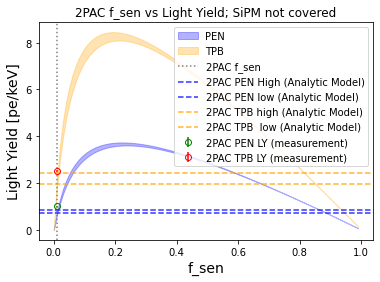

In [24]:
# F_sen value estimated for 2PAC
# f_sen_2PAC =  0.01176 

# %matplotlib qt
# %matplotlib inline

plt.close('2PAC f_sen vs LY, SiPM not covered')
plt.figure('2PAC f_sen vs LY, SiPM not covered')
# plt.plot(f_sen_vector, integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth, f_sen_vector,wls_eff = 0.47, Q_vis = Q_vis_2PAC, Q_vuv=Q_vuv_2PAC), '-g')
# plt.plot(f_sen_vector, integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth, f_sen_vector, Q_vis = Q_vis_2PAC, Q_vuv=Q_vuv_2PAC), '-r')
# f_sen_vector = np.arange(0, 0.05, 0.01)
f_sen_vector = np.arange(0, 1, 0.01)
LY_PEN_upper = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth, f_sen_vector, wls_eff= 0.47, Q_vis=Q_vis_2PAC, Q_vuv= Q_vuv_2PAC)
LY_PEN_lower = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth*0.988, f_sen_vector, wls_eff= 0.47, Q_vis=Q_vis_2PAC, Q_vuv= Q_vuv_2PAC)
plt.fill_between( f_sen_vector, LY_PEN_lower,  LY_PEN_upper, color='blue', alpha=0.3, label='PEN' )

LY_TPB_upper = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth, f_sen_vector, wls_eff=1, Q_vis=Q_vis_2PAC, Q_vuv=Q_vuv_2PAC)
LY_TPB_lower = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth*0.988, f_sen_vector, wls_eff=1, Q_vis=Q_vis_2PAC, Q_vuv=Q_vuv_2PAC)
plt.fill_between( f_sen_vector, LY_TPB_lower,  LY_TPB_upper, color='orange', alpha=0.3, label='TPB' )

### measurement values
plt.errorbar([0.01176], [2.50*0.40], yerr = [0.05*0.40], fmt ='o', mfc = 'none', color ='green', label = '2PAC PEN LY (measurement) ')
plt.errorbar([0.01176], [2.50], yerr = [0.05], fmt = 'o', mfc = 'none', color ='red', label = '2PAC TPB LY (measurement) ')

### horizontal lines correspond to the LY expected from 2PAC according to the Analytic Model
### ??? change f_sens from 0.01176 to 0.01

LY_PEN_2PAC_ref_high = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth, f_sen_2PAC, wls_eff= 0.47, Q_vis=Q_vis_2PAC, Q_vuv= Q_vuv_2PAC)
LY_PEN_2PAC_ref_low = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth*0.988, f_sen_2PAC, wls_eff= 0.47, Q_vis=Q_vis_2PAC, Q_vuv= Q_vuv_2PAC)

LY_TPB_2PAC_ref_high = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth, f_sen_2PAC, wls_eff=1, Q_vis=Q_vis_2PAC, Q_vuv=Q_vuv_2PAC)
LY_TPB_2PAC_ref_low = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth*0.988, f_sen_2PAC, wls_eff=1, Q_vis=Q_vis_2PAC, Q_vuv=Q_vuv_2PAC)

plt.axvline(f_sen_2PAC, 0, 1, linestyle = 'dotted', color = 'gray', label='2PAC f_sen')

plt.axhline(LY_PEN_2PAC_ref_high, 0, 1, linestyle = '--', color = 'blue', alpha =0.8, label='2PAC PEN High (Analytic Model)')
plt.axhline(LY_PEN_2PAC_ref_low, 0, 1, linestyle = '--', color = 'blue', alpha =0.8, label='2PAC PEN low (Analytic Model)')
plt.axhline(LY_TPB_2PAC_ref_high, 0, 1, linestyle = '--', color = 'orange', alpha =0.8, label='2PAC TPB high (Analytic Model)')
plt.axhline(LY_TPB_2PAC_ref_low, 0, 1, linestyle = '--', color = 'orange', alpha =0.8, label='2PAC TPB  low (Analytic Model)')

plt.ylabel('Light Yield [pe/keV]' , size =14, weight = 'bold')
plt.xlabel('f_sen', size =14, weight = 'bold')
plt.title('2PAC f_sen vs Light Yield; SiPM not covered')
### [R_SiPM, R_wall,PDE dependent on wavelength. Absorption and Rayleigh Scattering accounted for]
plt.legend(loc = 'best')
# plt.legend(loc = 'upper left')
# plt.savefig('f_sen vs LY')

<h4 style = 'color: red; font-size:14pt'>
    Note:
</h4>
<p>
One aspect in which segreto model differs is that it also calculates the probability of UV photons getting absorbed/scattered in the media (Argon in our case).
<br>
The original Analytic Model was only calculating the number of visible photons which will survive all the reflections. We were not looking at Scattering and Absorption effects at all. 
<br>
In the modified version of Analytic Model, we are taking into account absorption and scattering effect on both VUV as well as visible photons. We start with VUV photons, and then calculate how many VUV photons will survive absorption/scattering to reach a WLS and get converted to a visible photon. From here on we proceed similar to how we did in the old Analytic Model with one difference and that is this time we include the effect of scattering and absorption on visible photons as well.
<br>
One assumption of this whole calculation is that SIPM's have zero detection efficiency in VUV domain.
However in this case we are assuming WLS to be transparent to Visible photons. We can fix this by using WLS coupled reflectance values for SiPM.
<br>
<span style = 'color:tomato'>Explanation for LY curve decaying to zero when f_sen --> 1. </span>
<br>
This is pretty straight forward, actually, since SiPM are not covered with WLS, f_sen --> 1 means there is no surface which will shift VUV into visible photons. This leads to zero light collection and hence zero light yield.
<br>
<span style = 'color: tomato'> In case SiPM's are also covered with WLS. </span>
<br>
The following plot shows how light yield will vary as we keep increasing fraction of surface covered with WLS while SiPM's are also covered with WLS. Point to be noted is that the curves are still NOT monotonically increasing. I have marked the maximum light yield with stars in the plot. in case of TPB maximum LY is achieved with f_sen = 0.80 while for PEN maximum LY is achieved when f_sen = 0.93
<br>
<b style = 'color: deeppink'> Tl; DR </b>
<br>
f_sen =1 means no wavelength shifter and hence zero light yield
</p>

<h4 style = 'color: yellow'> <b style = 'color:  red; font-family:Times New Roman;' > II. </b>    When SiPM is also covered with WLS </h4>
<p> Right now we are not accounting for any reflection/absorption of visible light in WSL. To remedy this we should use reflectances values of WLS coupled with SiPM. </p>

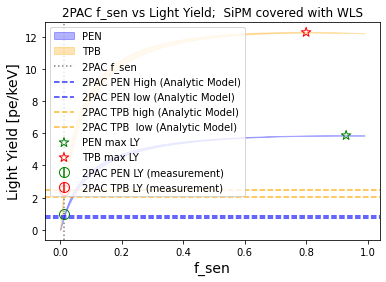

In [25]:
# F_sen value estimated for 2PAC
# f_sen_2PAC =  0.01176 

# %matplotlib qt
# %matplotlib inline

plt.close('2PAC f_sen vs LY')
plt.figure('2PAC f_sen vs LY')
# plt.plot(f_sen_vector, integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth, f_sen_vector,wls_eff = 0.47, Q_vis = Q_vis_2PAC, Q_vuv=Q_vuv_2PAC), '-g')
# plt.plot(f_sen_vector, integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth, f_sen_vector, Q_vis = Q_vis_2PAC, Q_vuv=Q_vuv_2PAC), '-r')
# f_sen_vector = np.arange(0, 0.05, 0.01)
f_sen_vector = np.arange(0, 1, 0.01)
LY_PEN_upper = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth, f_sen_vector, wls_eff= 0.47, Q_vis=Q_vis_2PAC, Q_vuv= Q_vuv_2PAC, SiPM_covered =True)
LY_PEN_lower = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth*0.988, f_sen_vector, wls_eff= 0.47, Q_vis=Q_vis_2PAC, Q_vuv= Q_vuv_2PAC, SiPM_covered =True)
plt.fill_between( f_sen_vector, LY_PEN_lower,  LY_PEN_upper, color='blue', alpha=0.3, label='PEN' )

LY_TPB_upper = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth, f_sen_vector, wls_eff=1, Q_vis=Q_vis_2PAC, Q_vuv=Q_vuv_2PAC, SiPM_covered =True)
LY_TPB_lower = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth*0.988, f_sen_vector, wls_eff=1, Q_vis=Q_vis_2PAC, Q_vuv=Q_vuv_2PAC, SiPM_covered =True)
plt.fill_between( f_sen_vector, LY_TPB_lower,  LY_TPB_upper, color='orange', alpha=0.3, label='TPB' )

### measurement values
plt.errorbar([0.01176], [2.50*0.40], yerr = [0.05*0.40], fmt ='o', markersize = 10, color ='green', mfc = 'none', label = '2PAC PEN LY (measurement) ')
plt.errorbar([0.01176], [2.50], yerr = [0.05], fmt = 'o', markersize =10, color ='red', mfc = 'none', label = '2PAC TPB LY (measurement) ')

### horizontal lines correspond to the LY expected from 2PAC according to the Analytic Model
### ??? change f_sens from 0.01176 to 0.01

LY_PEN_2PAC_ref_high = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth, f_sen_2PAC, wls_eff= 0.47, Q_vis=Q_vis_2PAC, Q_vuv= Q_vuv_2PAC, SiPM_covered =True)
LY_PEN_2PAC_ref_low = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth*0.988, f_sen_2PAC, wls_eff= 0.47, Q_vis=Q_vis_2PAC, Q_vuv= Q_vuv_2PAC, SiPM_covered =True)

LY_TPB_2PAC_ref_high = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth, f_sen_2PAC, wls_eff=1, Q_vis=Q_vis_2PAC, Q_vuv=Q_vuv_2PAC, SiPM_covered =True)
LY_TPB_2PAC_ref_low = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth*0.988, f_sen_2PAC, wls_eff=1, Q_vis=Q_vis_2PAC, Q_vuv=Q_vuv_2PAC, SiPM_covered =True)

plt.axvline(f_sen_2PAC, 0, 1, linestyle = 'dotted', color = 'gray', label='2PAC f_sen')

plt.axhline(LY_PEN_2PAC_ref_high, 0, 1, linestyle = '--', color = 'blue', alpha =0.8, label='2PAC PEN High (Analytic Model)')
plt.axhline(LY_PEN_2PAC_ref_low, 0, 1, linestyle = '--', color = 'blue', alpha =0.8, label='2PAC PEN low (Analytic Model)')
plt.axhline(LY_TPB_2PAC_ref_high, 0, 1, linestyle = '--', color = 'orange', alpha =0.8, label='2PAC TPB high (Analytic Model)')
plt.axhline(LY_TPB_2PAC_ref_low, 0, 1, linestyle = '--', color = 'orange', alpha =0.8, label='2PAC TPB  low (Analytic Model)')

### Maximum LY points
LY_PEN_average = (LY_PEN_upper + LY_PEN_lower)/2
LY_TPB_average = (LY_TPB_upper + LY_TPB_lower)/2

plt.scatter( f_sen_vector[np.argmax(LY_PEN_average)], LY_PEN_average[np.argmax(LY_PEN_average)], marker = '*', s =100, facecolors = 'none', edgecolors = 'g', label = 'PEN max LY')
plt.scatter( f_sen_vector[np.argmax(LY_TPB_average)], LY_TPB_average[np.argmax(LY_TPB_average)], marker = '*', s =100, facecolors = 'none', edgecolors ='r', label = 'TPB max LY')

plt.ylabel('Light Yield [pe/keV]' , size =14, weight = 'bold')
plt.xlabel('f_sen', size =14, weight = 'bold')
plt.title('2PAC f_sen vs Light Yield;  SiPM covered with WLS')
### [R_SiPM, R_wall,PDE dependent on wavelength. Absorption and Rayleigh Scattering accounted for]
# plt.legend(loc = 'best')
plt.legend(loc = 'upper left')
# plt.savefig('f_sen vs LY')

In [26]:
LY_TPB_average = (LY_TPB_upper + LY_TPB_lower)/2

f_sen_vector[np.argmax(LY_TPB_average)] ### at this value we'll obtain the maximum light yield

0.8

In [27]:
LY_PEN_average = (LY_PEN_upper + LY_PEN_lower)/2

f_sen_vector[np.argmax(LY_PEN_average)] ### at this value we'll obtain the maximum light yield

0.93

<h2 style = 'color:orange'> DarkSide-20k Muon veto </h2>
<p style = 'color:skyblue'> in case of DarkSide veto we no longer have the symmetry. First the shape is not a cylinder; it has spherical caps on each end. The TPC inside the titanium vessel works like a cavity with additional surface area. We have to come with a technique to account for these differences. </p>

In [28]:
### volume needed to contain 20,000 Kg of liquid Argon
### Desnity of liquid Argon is 	1395.4 Kg/ m^3

print('volume of LAr that would weigh 20 ton:', 20000/1395.4, 'm^3')

volume of LAr that would weigh 20 ton: 14.33280779704744 m^3


<p style = 'color:violet; font-size:14pt'> Titanium Vessel </p>
<span style = 'color : lime; font-size: 14pt;'>
    $$
    \text{volume of titanium vessel} = \pi R^2 H + 2 \times \frac{1}{6} \pi h(3a^2+h^2)
    $$
    <br>
    $$
    \text{internal surface area of titanium vessel} = 2 \pi R H + 2 \times \pi (a^2 + h^2)
    $$
</span>

In [29]:
### we will calculate the surface area and volume of titanium using above formulas
### Note : radois of cylinder =  radius of spherical cap, lets call it vessel radius 
### Radius of cap is not same as the radius of sphere from which it was cut.
### Link: https://en.wikipedia.org/wiki/Spherical_cap

def calc_vessel_volume(R, H, a, h):
    ''' R and H are the radius and height of the cylinder.
    a and h are the radius and height of the spherical cap. '''

    return np.pi*(R**2)*H + 2*(1/6)*np.pi*h*(3*(a**2) + h**2)

def calc_vessel_surface_area(R, H, a, h):

    return 2*np.pi*R*H + 2*np.pi*(a**2+h**2)

### values given by Marcin
# vessel_volume = 80;

### values given by Shawn
cylinder_height = 3.572;
cap_height = 0.91688;
vessel_radius = 2.335;

# vessel_surface_area = 91.9;

vessel_surface_area = calc_vessel_surface_area(R=vessel_radius, H= cylinder_height, a= vessel_radius, h=cap_height)

vessel_volume = calc_vessel_volume(R=vessel_radius, H= cylinder_height, a=vessel_radius, h=cap_height)

print('vessel_surface_area :', vessel_surface_area, '\n', 'vessel_volume :', vessel_volume)

vessel_surface_area : 91.94507974502982 
 vessel_volume : 77.69571626786087


<p style = 'color:violet; font-size:14pt'> TPC : octagonal prism  </p>
<span style = 'color : lime; font-size:14pt'>
    $$
    \text{Surface area of a regular octagonal prism} = 8 \times a \times h
    $$
    <br>
    $$
    \text{Volume of a regular octagonal prism} = 2 \times (1 + \sqrt{2}) \times a^2 \times h
    $$
</span>

In [30]:
TPC_height = (348+30)/100;
TPC_parallel_distance = (350 +30)/100;
TPC_side = TPC_parallel_distance/abs(np.tan( np.radians(135/2) ));
TPC_surface_area = 8*TPC_side*TPC_height;
TPC_volume = 2*(1+2**0.5)*TPC_side**2*TPC_height;
print('TPC_side: ', TPC_side, '\n','TPC_surface_area:', TPC_surface_area, '\n', 'TPC_volume:', TPC_volume)

TPC_side:  1.5740115370177612 
 TPC_surface_area: 47.5981088794171 
 TPC_volume: 45.21820343544624


In [31]:
effective_veto_volume = vessel_volume - TPC_volume;
effective_veto_surface_area = vessel_surface_area + TPC_surface_area;
print('effective_veto_surface_area:', effective_veto_surface_area, '\n', 'effective_veto_volume:', effective_veto_volume)

effective_veto_surface_area: 139.5431886244469 
 effective_veto_volume: 32.47751283241463


In [32]:
ds_veto_char_length = calc_length(volume= effective_veto_volume, area= effective_veto_surface_area)
print( 'ds_veto_char_length: ', ds_veto_char_length)

ds_veto_char_length:  1.3964499372228685


In [33]:
### calculating Q for Argon filled DarkSide Veto
Q_vis_ds_veto = calc_Q( ds_veto_char_length, lambda_abs= 100, lambda_R= 300)
Q_vuv_ds_veto = calc_Q( ds_veto_char_length, lambda_abs= 17, lambda_R= 0.97)

print('Q_vuv_ds_veto: ',  Q_vuv_ds_veto, '\n', 'Q_vis_ds_veto :',Q_vis_ds_veto)

Q_vuv_ds_veto:  1.0511080712694048 
 Q_vis_ds_veto : 1.0070039170323342


<h4 style = 'color: yellow;'> <b style = 'color:  red; font-family:Times New Roman;' > I. </b> DarkSide muon veto SiPM not covered </h4>

Text(0.5, 1.0, 'DarkSide-20k muon veto SiPM not covered')

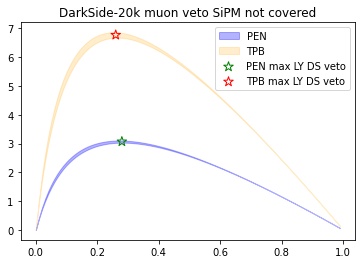

In [34]:
### DarkSide muon veto SiPM not covered
plt.close('DarkSide f_sen vs LY SiPM not covered')
plt.figure('DarkSide f_sen vs LY SiPM not covered')

LY_PEN_upper_ds_veto = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth, f_sen_vector, wls_eff= 0.47, Q_vis=Q_vis_ds_veto, Q_vuv= Q_vuv_ds_veto)
LY_PEN_lower_ds_veto = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth*0.988, f_sen_vector, wls_eff= 0.47, Q_vis=Q_vis_ds_veto, Q_vuv= Q_vuv_ds_veto)
plt.fill_between( f_sen_vector, LY_PEN_lower_ds_veto,  LY_PEN_upper_ds_veto, color='blue', alpha=0.3, label='PEN' )

LY_TPB_upper_ds_veto = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth, f_sen_vector, wls_eff=1, Q_vis=Q_vis_ds_veto, Q_vuv=Q_vuv_ds_veto)
LY_TPB_lower_ds_veto = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth*0.988, f_sen_vector, wls_eff=1, Q_vis=Q_vis_ds_veto, Q_vuv=Q_vuv_ds_veto)
plt.fill_between( f_sen_vector, LY_TPB_lower_ds_veto,  LY_TPB_upper_ds_veto, color='orange', alpha=0.2, label='TPB' )

### Maximum LY points
LY_PEN_average_ds_veto = (LY_PEN_upper_ds_veto + LY_PEN_lower_ds_veto)/2;
LY_TPB_average_ds_veto = (LY_TPB_upper_ds_veto + LY_TPB_lower_ds_veto)/2;

plt.scatter( f_sen_vector[np.argmax(LY_PEN_average_ds_veto)], LY_PEN_average_ds_veto[np.argmax(LY_PEN_average_ds_veto)], marker = '*', s =100, facecolors = 'none', edgecolors = 'g', label = 'PEN max LY DS veto')
plt.scatter( f_sen_vector[np.argmax(LY_TPB_average_ds_veto)], LY_TPB_average_ds_veto[np.argmax(LY_TPB_average_ds_veto)], marker = '*', s =100, facecolors = 'none', edgecolors ='r', label = 'TPB max LY DS veto')
plt.legend()
plt.title('DarkSide-20k muon veto SiPM not covered')

<h4 style = 'color: yellow'> <b style = 'color:  red; font-family:Times New Roman;' > II. </b> DarkSide muon veto SiPM covered with WLS </h4>

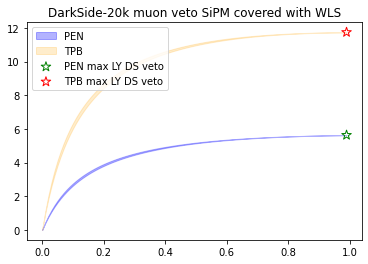

In [35]:
### DarkSide veto SiPM covered with WLS
# %matplotlib qt
plt.close('DarkSide f_sen vs LY SiPM covered with WLS')
plt.figure('DarkSide f_sen vs LY SiPM covered with WLS')
### the parameter f_sen is a little trciky here. We may not be able to cover TPC surface with SiPM's in that case f_sen =1 is not feasible.

LY_PEN_upper_ds_veto = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth, f_sen_vector, wls_eff= 0.47, Q_vis=Q_vis_ds_veto, Q_vuv= Q_vuv_ds_veto, SiPM_covered=True);
LY_PEN_lower_ds_veto = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth*0.988, f_sen_vector, wls_eff= 0.47, Q_vis=Q_vis_ds_veto, Q_vuv= Q_vuv_ds_veto, SiPM_covered=True);
plt.fill_between( f_sen_vector, LY_PEN_lower_ds_veto,  LY_PEN_upper_ds_veto, color='blue', alpha=0.3, label='PEN' )

LY_TPB_upper_ds_veto = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth, f_sen_vector, wls_eff=1, Q_vis=Q_vis_ds_veto, Q_vuv=Q_vuv_ds_veto, SiPM_covered=True)
LY_TPB_lower_ds_veto = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth*0.988, f_sen_vector, wls_eff=1, Q_vis=Q_vis_ds_veto, Q_vuv=Q_vuv_ds_veto, SiPM_covered=True)
plt.fill_between( f_sen_vector, LY_TPB_lower_ds_veto,  LY_TPB_upper_ds_veto, color='orange', alpha=0.2, label='TPB' )

### Maximum LY points
LY_PEN_average_ds_veto = (LY_PEN_upper_ds_veto + LY_PEN_lower_ds_veto)/2;
LY_TPB_average_ds_veto = (LY_TPB_upper_ds_veto + LY_TPB_lower_ds_veto)/2;

plt.scatter( f_sen_vector[np.argmax(LY_PEN_average_ds_veto)], LY_PEN_average_ds_veto[np.argmax(LY_PEN_average_ds_veto)], marker = '*', s =100, facecolors = 'none', edgecolors = 'g', label = 'PEN max LY DS veto')
plt.scatter( f_sen_vector[np.argmax(LY_TPB_average_ds_veto)], LY_TPB_average_ds_veto[np.argmax(LY_TPB_average_ds_veto)], marker = '*', s =100, facecolors = 'none', edgecolors ='r', label = 'TPB max LY DS veto')

plt.legend()
plt.title('DarkSide-20k muon veto SiPM covered with WLS')
plt.legend(loc = 'upper left')

<p> 
    <span style = 'color: red; font-size:14pt'> Warning!! </span>
    <span style = 'color: skyblue; font-size: 14pt;'> The above plot 'DarkSide-20k muon veto SiPM covered with WLS' is unrealistic not just because of the model but also because of the fact that f_sen will be limited by the available surface in such a setting. The maximum feasible value of f_sen can be found in this manner: </span>
    <br>
    <span style = 'font-size: 12pt; text-align: center;'> vessel_surface_area/effective_veto_surface_area 
</span>
</p>

In [36]:
vessel_surface_area/effective_veto_surface_area

0.6589005214183685

<h2 style= 'color: orange'> ARGO </h2>

In [37]:
### First we will calculate the characteristic length for ARGO, Characteristic length as defined in Segreto paper
area_ARGO = 2*np.pi*(7.05/2)*( 7.05/2 + 7.05)
volume_ARGO = np.pi*(7.05)*(7.05/2)**2

L_char_ARGO = calc_length(area_ARGO, volume_ARGO) ### unit: m

In [38]:
### calculating Q for Argon filled ARGO
Q_vis_ARGO = calc_Q(L_char_ARGO, lambda_abs= 100, lambda_R= 300)
Q_vuv_ARGO = calc_Q(L_char_ARGO, lambda_abs= 17, lambda_R= 0.97)

In [39]:
# area_ARGO,
# volume_ARGO,
# L_char_ARGO
# L_char_ARGO

In [40]:
f_sen_min = (np.pi*(7.05/2)**2)/area_ARGO
f_sen_vector = np.arange(f_sen_min,1, 0.001)
# f_sen_vector = np.arange(0,1, 0.001)
# f_sen_vector

<h4 style = 'color: yellow;'> <b style = 'font-family: Times New Roman; color : red; '> I.  </b> Plots for different wall reflectances . </h4>

<p style = 'color: red'> Note : </p>
<p style = 'color: yellow;'> SiPM covered with WLS. 
    TPB wavelength shifter 
</p>

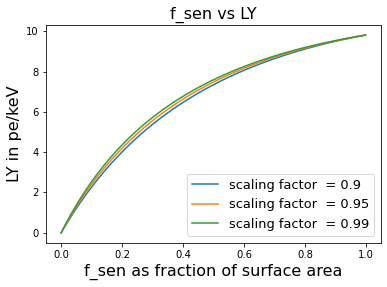

In [41]:
# %matplotlib qt
%matplotlib inline

fig1 = plt.figure('1')
ax1 = plt.axes()
f_sen_vector = np.arange(0,1, 0.001)
for scale_factor in [0.90, 0.95, 0.99]:
    LY_TPB_upper_ARGO_1 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth,
                                       scale_factor*R_Wall_TPB_smooth, f_sen_vector, wls_eff= 1, Q_vis=Q_vis_ARGO, Q_vuv= Q_vuv_ARGO, SiPM_covered =True)
    ax1.plot(f_sen_vector, LY_TPB_upper_ARGO_1, label = 'scaling factor  = ' + str(scale_factor))
    ### maximum locator
    # ax1.scatter( f_sen_vector[np.argmax(LY_TPB_upper_ARGO_1)], LY_TPB_upper_ARGO_1[np.argmax(LY_TPB_upper_ARGO_1)], marker = '*', s =100)

ax1.set_title('f_sen vs LY', size =16, weight = 'bold')
ax1.set_xlabel('f_sen as fraction of surface area', size =16, weight = 'bold')
ax1.set_ylabel('LY in pe/keV', size =16, weight = 'bold')
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# txtstr = '* represents max LY'
# ax1.text(0.15, 0.95, txtstr, transform=ax1.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax1.set_yscale('linear')
ax1.legend(loc ='best',  prop={'size': 13})

<h4 style = 'color: yellow;'> <b style = 'font-family: Times New Roman; color : red; '> II.  </b> Plots for VUV absorption lengths 5, 10, 20, 100. </h4>

<p style = 'color: red'> Note : </p>
<p style = 'color: yellow;'> SiPM covered with WLS. 
    TPB wavelength shifter.
    TPB reflectance scaled by 0.95
</p>

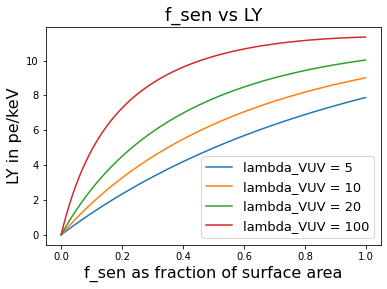

In [42]:
# %matplotlib qt
%matplotlib inline
fig2 = plt.figure('2')
ax2 = plt.axes()
for lambda_variable in [5, 10, 20, 100]:
    Q_vuv_ARGO_variable = calc_Q(L_char_ARGO, lambda_abs=lambda_variable, lambda_R=0.97)
    LY_TPB_upper_ARGO_2 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth,
                                       0.95*R_Wall_TPB_smooth, f_sen_vector, wls_eff= 1, Q_vis=Q_vis_ARGO, Q_vuv= Q_vuv_ARGO_variable, SiPM_covered =True)
    ax2.plot(f_sen_vector, LY_TPB_upper_ARGO_2, label = 'lambda_VUV = ' + str(lambda_variable))

ax2.set_title('f_sen vs LY', size =18, weight = 'bold')
ax2.set_xlabel('f_sen as fraction of surface area', size =16, weight = 'bold')
ax2.set_ylabel('LY in pe/keV', size =16, weight = 'bold')
ax2.legend(loc ='best', prop={'size': 13})

In [43]:
# fig1.show()

In [44]:
# fig2.show()

In [45]:
# %matplotlib inline
# ### testing for veto like configuration
# fig1 = plt.figure('3')
# ax1 = plt.axes()
# LY_TPB_upper_ARGO_1 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth, 
#                                    f_sen_vector, wls_eff= 1.00, Q_vis=Q_vis_ARGO, Q_vuv= Q_vuv_ARGO, SiPM_covered =False)

# LY_PEN_upper_ARGO_1 = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth, 
#                                    f_sen_vector, wls_eff= 0.47, Q_vis=Q_vis_ARGO, Q_vuv= Q_vuv_ARGO, SiPM_covered =False)

# ax1.plot(f_sen_vector, LY_TPB_upper_ARGO_1, label = 'TPB')
# ax1.plot(f_sen_vector, LY_PEN_upper_ARGO_1, label = 'PEN')
# ### ON
# LY_TPB_upper_ARGO_2 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth, 
#                                    f_sen_vector, wls_eff= 1.00, Q_vis=Q_vis_ARGO, Q_vuv= Q_vuv_ARGO, SiPM_covered =True)

# LY_PEN_upper_ARGO_2 = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth, 
#                                    f_sen_vector, wls_eff= 0.47, Q_vis=Q_vis_ARGO, Q_vuv= Q_vuv_ARGO, SiPM_covered =True)

# ax1.plot(f_sen_vector, LY_TPB_upper_ARGO_2, label = 'TPB SiPM covered',color = 'red') #,  marker = '*')
# ax1.plot(f_sen_vector, LY_PEN_upper_ARGO_2, label = 'PEN SiPM covered', color = 'purple') # ,  marker = 'v')

# # ax1.set_xticks()
# ### ON

# ax1.set_title('SiPM not covered', size =16, weight = 'bold')
# ax1.set_xlabel('f_sen as fraction of surface area', size =16, weight = 'bold')
# ax1.set_ylabel('LY in pe/keV', size =16, weight = 'bold')
# # props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# # txtstr = '* represents max LY'
# # ax1.text(0.15, 0.95, txtstr, transform=ax1.transAxes, fontsize=14, verticalalignment='top', bbox=props)
# ax1.set_yscale('linear')
# ax1.legend(loc ='best',  prop={'size': 13})

In [46]:
# ### SiPM covered = True
# LY_TPB_upper_ARGO_2 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth, 
#                                    f_sen_vector, wls_eff= 1.00, Q_vis=Q_vis_ARGO, Q_vuv= Q_vuv_ARGO, SiPM_covered =True)

# LY_PEN_upper_ARGO_2 = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth, 
#                                    f_sen_vector, wls_eff= 0.47, Q_vis=Q_vis_ARGO, Q_vuv= Q_vuv_ARGO, SiPM_covered =True)
# fig6 = plt.figure()
# ax6 = plt.axes()

# ax6.plot(f_sen_vector, LY_TPB_upper_ARGO_2, label = 'TPB', color = 'red')
# ax6.plot(f_sen_vector, LY_PEN_upper_ARGO_2, label = 'PEN', color = 'purple')

# ### maximum locator
# # ax1.scatter( f_sen_vector[np.argmax(LY_TPB_upper_ARGO_1)], LY_TPB_upper_ARGO_1[np.argmax(LY_TPB_upper_ARGO_1)], marker = '*', s =100)

# ax6.set_title('SiPM covered', size =16, weight = 'bold')
# ax6.set_xlabel('f_sen as fraction of surface area', size =16, weight = 'bold')
# ax6.set_ylabel('LY in pe/keV', size =16, weight = 'bold')
# # props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# # txtstr = '* represents max LY'
# # ax1.text(0.15, 0.95, txtstr, transform=ax1.transAxes, fontsize=14, verticalalignment='top', bbox=props)
# ax6.set_yscale('linear')
# ax6.legend( loc ='best',  prop={'size': 13} )

In [47]:
# ax1.plot(f_sen_vector, LY_TPB_upper_ARGO_2, label = 'TPB', marker = '*')
# ax1.plot(f_sen_vector, LY_PEN_upper_ARGO_2, label = 'PEN', marker = 'v')

In [48]:
# Changing Q values

In [49]:
# # Something is wrong here
# # %matplotlib qt
# %matplotlib inline
# ### testing for veto like configuration
# # Q_vis_ARGO = 2 # these values are what is wrong with this cell
# # Q_vuv_ARGO = 2
# # Q_vis_ARGO = 1.0070039170323342; # values taken from Darkside muon veto
# # Q_vuv_ARGO = 1.0511080712694048
# fig1 = plt.figure('3')
# ax1 = plt.axes()

# LY_TPB_upper_ARGO_1 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth, 
#                                    f_sen_vector, wls_eff= 1.00, Q_vis=Q_vis_ARGO, Q_vuv= Q_vuv_ARGO, SiPM_covered =False)

# LY_PEN_upper_ARGO_1 = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth, 
#                                    f_sen_vector, wls_eff= 0.47, Q_vis=Q_vis_ARGO, Q_vuv= Q_vuv_ARGO, SiPM_covered =False)

# ax1.plot(f_sen_vector, LY_TPB_upper_ARGO_1, label = 'TPB')
# ax1.plot(f_sen_vector, LY_PEN_upper_ARGO_1, label = 'PEN')
# ### ON
# LY_TPB_upper_ARGO_2 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth, 
#                                    f_sen_vector, wls_eff= 1.00, Q_vis=Q_vis_ARGO, Q_vuv= Q_vuv_ARGO, SiPM_covered =True)

# LY_PEN_upper_ARGO_2 = integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth, 
#                                    f_sen_vector, wls_eff= 0.47, Q_vis=Q_vis_ARGO, Q_vuv= Q_vuv_ARGO, SiPM_covered =True)

# ax1.plot(f_sen_vector, LY_TPB_upper_ARGO_2, label = 'TPB SiPM covered') #, marker = '*')
# ax1.plot(f_sen_vector, LY_PEN_upper_ARGO_2, label = 'PEN SiPM covered') #, marker = 'v')
# ### ON

# ax1.set_title('SiPM not covered', size =16, weight = 'bold')
# ax1.set_xlabel('f_sen as fraction of surface area', size =16, weight = 'bold')
# ax1.set_ylabel('LY in pe/keV', size =16, weight = 'bold')
# # props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# # txtstr = '* represents max LY'
# # ax1.text(0.15, 0.95, txtstr, transform=ax1.transAxes, fontsize=14, verticalalignment='top', bbox=props)
# ax1.set_yscale('linear')
# ax1.legend(loc ='best',  prop={'size': 13})

<h2 style = 'color: deeppink'>⭐ Q value and LY </h2>
<p>
    This raises serious concerns about size of detector.
</p>

In [50]:
# Q values seem to have a drastic effect on LY.
# plot showing effect of different parameter on Q
# plot showing effect of Q on Light Yield

In [51]:
print('Characteristic Lengths', '\n', '2PAC: ', L_char_2PAC, '\n', 'DS muon veto: ', ds_veto_char_length, '\n',
      'ARGO: ', L_char_ARGO)

Characteristic Lengths 
 2PAC:  0.05584383331023524 
 DS muon veto:  1.3964499372228685 
 ARGO:  7.050000000000001


In [52]:
Q_vis_2PAC = calc_Q(L_char_2PAC, lambda_abs= 100, lambda_R= 300)
Q_vuv_ARGO = calc_Q(L_char_2PAC, lambda_abs= 17, lambda_R= 0.97)
# Q_vuv_2PAC = calc_Q(L_char_2PAC, lambda_abs= 100000, lambda_R= 100000) # sanity check value of lambda_abs set at 1000

In [53]:
Q_vis_ds_veto = calc_Q(ds_veto_char_length, lambda_abs= 100, lambda_R= 300)
Q_vuv_ARGO = calc_Q(ds_veto_char_length, lambda_abs= 17, lambda_R= 0.97)
# Q_vuv_ds_veto = calc_Q(ds_veto_char_length, lambda_abs= 100000, lambda_R= 100000) # sanity check value of lambda_abs set at 1000

In [54]:
Q_vis_ARGO = calc_Q(L_char_ARGO, lambda_abs= 100, lambda_R= 300)
Q_vuv_ARGO = calc_Q(L_char_ARGO, lambda_abs= 17, lambda_R= 0.97)
# Q_vuv_ARGO = calc_Q(L_char_ARGO, lambda_abs= 100000, lambda_R= 100000) # sanity check value of lambda_abs set at 1000

In [55]:
print('Q_VUV: ', '\n', '2PAC: ', Q_vuv_2PAC, '\n', 'DS Muon veto: ',  Q_vuv_ds_veto, '\n', 'ARGO: ', Q_vuv_ARGO)

Q_VUV:  
 2PAC:  1.0016591236102481 
 DS Muon veto:  1.0511080712694048 
 ARGO:  1.3609181748974062


In [56]:
print('Q_vis:', '\n', '2PAC: ', Q_vis_2PAC, '\n', 'DS Muon veto: ',  Q_vis_ds_veto, '\n', 'ARGO: ', Q_vis_ARGO)

Q_vis: 
 2PAC:  1.0002792538169047 
 DS Muon veto:  1.0070039170323342 
 ARGO:  1.0358021686890884


In [57]:
Q_vuv_vector = []
Q_vis_vector = []
for length_variable in np.arange(0.1, 10, 0.1):
    Q_vuv_vector.append(calc_Q(L_char=length_variable, lambda_abs=17, lambda_R=0.97))
    Q_vis_vector.append(calc_Q(L_char=length_variable, lambda_abs= 100, lambda_R= 300))

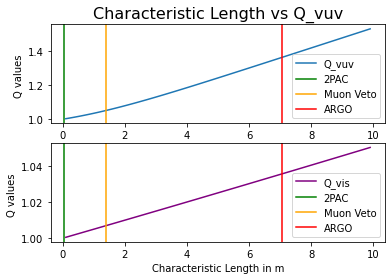

In [58]:
# %matplotlib qt
%matplotlib inline
fig12=plt.figure('12')
ax12 = plt.subplot(2, 1, 1)
ax12.plot(np.arange(0.1, 10, 0.1), Q_vuv_vector, label='Q_vuv')
ax12.set_xlabel('Characteristic Length in m')
ax12.set_ylabel('Q values ')
ax12.axvline(L_char_2PAC, c='g', label='2PAC')
ax12.axvline(ds_veto_char_length, c='orange', label='Muon Veto')
ax12.axvline(L_char_ARGO, c='r', label='ARGO')
ax12.legend(loc='best')
ax12.set_title('Characteristic Length vs Q_vuv', size=16, weight='bold')

ax12 = plt.subplot(2, 1, 2)
ax12.plot(np.arange(0.1, 10, 0.1), Q_vis_vector, label='Q_vis', c= 'purple')
ax12.set_xlabel('Characteristic Length in m')
ax12.set_ylabel('Q values ')
ax12.axvline(L_char_2PAC, c='g', label='2PAC')
ax12.axvline(ds_veto_char_length, c='orange', label='Muon Veto')
ax12.axvline(L_char_ARGO, c='r', label='ARGO')
ax12.legend(loc='best')

<h4 style = 'color : magenta'> SiPM's not coverd with WLS </h4>

In [59]:
LY_vector_1 = []
Q_feasible_values = np.arange(1, 2, 0.01)

for Q_variable in Q_feasible_values:
    LY_vector_1.append(integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                  f_sen=0.1, Q_vis=Q_vis_ARGO, Q_vuv=Q_variable,
                                  SiPM_covered=False))

LY_ARGO_1 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                       f_sen=0.1, Q_vis=Q_vis_ARGO, Q_vuv=Q_vuv_ARGO, SiPM_covered=False)
LY_2PAC_1 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                  f_sen=0.1, Q_vis=Q_vis_2PAC, Q_vuv=Q_vuv_2PAC,
                                  SiPM_covered=False)
LY_DS_muon_veto_1 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                  f_sen=0.1, Q_vis=Q_vis_ds_veto, Q_vuv=Q_vuv_ds_veto,
                                  SiPM_covered=False)

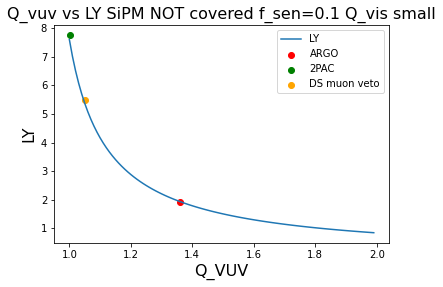

In [60]:
# %matplotlib inline
# %matplotlib qt
fig14 = plt.figure('14')
ax14 = plt.axes()
ax14.plot(Q_feasible_values, LY_vector_1, label='LY')
ax14.set_yscale('linear')
ax14.legend(loc='best')
ax14.set_xlabel('Q_VUV', size=16, weight='bold')
ax14.set_ylabel('LY', size=16, weight='bold')
ax14.scatter(Q_vuv_ARGO, LY_ARGO_1, label='ARGO', color='red')
ax14.scatter(Q_vuv_2PAC, LY_2PAC_1, label='2PAC', color='green')
ax14.scatter(Q_vuv_ds_veto, LY_DS_muon_veto_1, label='DS muon veto', color='orange')
ax14.set_title('Q_vuv vs LY SiPM NOT covered f_sen=0.1 Q_vis small', size=16, weight='bold')
ax14.legend()

In [61]:
'ARGO LY:', integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                  f_sen=0.1, Q_vis=Q_vis_ARGO, Q_vuv=Q_vuv_ARGO,
                                  SiPM_covered=False)

('ARGO LY:', 1.9326369620988664)

In [62]:
'DS Muon Veto LY:', integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                  f_sen=0.1, Q_vis=Q_vis_ds_veto, Q_vuv=Q_vuv_ds_veto,
                                  SiPM_covered=False)

('DS Muon Veto LY:', 5.489852508988709)

In [63]:
'2PAC LY:', integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                  f_sen=0.1, Q_vis=Q_vis_2PAC, Q_vuv=Q_vuv_2PAC,
                                  SiPM_covered=False)

('2PAC LY:', 7.762256542634427)

<h4 style = 'color : magenta'> SiPM's coverd with WLS </h4>

In [64]:
LY_vector_2 = []
Q_feasible_values = np.arange(1, 2, 0.01)

for Q_variable in Q_feasible_values:
    LY_vector_2.append(integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                  f_sen=0.1, Q_vis=Q_vis_ARGO, Q_vuv=Q_variable,
                                  SiPM_covered=True))
LY_ARGO_2 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                       f_sen=0.1, Q_vis=Q_vis_ARGO, Q_vuv=Q_vuv_ARGO, SiPM_covered=True)
LY_2PAC_2 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                  f_sen=0.1, Q_vis=Q_vis_2PAC, Q_vuv=Q_vuv_2PAC,
                                  SiPM_covered=True)
LY_DS_muon_veto_2 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                  f_sen=0.1, Q_vis=Q_vis_ds_veto, Q_vuv=Q_vuv_ds_veto,
                                  SiPM_covered=True)

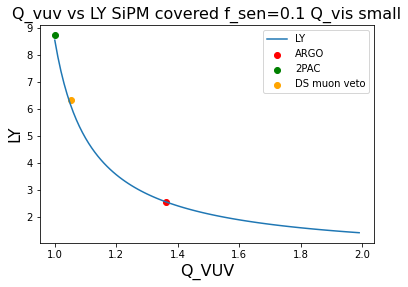

In [65]:
# %matplotlib inline
# %matplotlib qt
fig15 = plt.figure('15')
ax15 = plt.axes()
ax15.plot(Q_feasible_values, LY_vector_2, label='LY')
ax15.set_yscale('linear')
ax15.legend(loc='best')
ax15.set_xlabel('Q_VUV', size=16, weight='bold')
ax15.set_ylabel('LY', size=16, weight='bold')
ax15.scatter(Q_vuv_ARGO, LY_ARGO_2, label='ARGO', color='red')
ax15.scatter(Q_vuv_2PAC, LY_2PAC_2, label='2PAC', color='green')
ax15.scatter(Q_vuv_ds_veto, LY_DS_muon_veto_2, label='DS muon veto', color='orange')
ax15.set_title('Q_vuv vs LY SiPM covered f_sen=0.1 Q_vis small', size=16, weight='bold')
ax15.legend()

In [66]:
'ARGO LY:', integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                  f_sen=0.1, Q_vis=Q_vis_ARGO, Q_vuv=Q_vuv_ARGO,
                                  SiPM_covered=True)

('ARGO LY:', 2.5714188842725414)

In [67]:
'DS Muon Veto LY: ', integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                  f_sen=0.1, Q_vis=Q_vis_ds_veto, Q_vuv=Q_vuv_ds_veto,
                                  SiPM_covered=True)

('DS Muon Veto LY: ', 6.341454847386831)

In [68]:
'2PAC LY:', integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                  f_sen=0.1, Q_vis=Q_vis_2PAC, Q_vuv=Q_vuv_2PAC,
                                  SiPM_covered=True)

('2PAC LY:', 8.743778295121725)

<h4 style = 'color : Magenta'> Q_vis vs LY when SiPM's coverd with WLS </h4>

In [69]:
LY_vector_3 = []
Q_feasible_values = np.arange(1.0, 1.1, 0.0001)

for Q_variable in Q_feasible_values:
    LY_vector_3.append(integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                  f_sen=0.1, Q_vis=Q_variable, Q_vuv=Q_vuv_ARGO,
                                  SiPM_covered=True))
LY_ARGO_3 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                       f_sen=0.1, Q_vis=Q_vis_ARGO, Q_vuv=Q_vuv_ARGO, SiPM_covered=True)
LY_2PAC_3 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                  f_sen=0.1, Q_vis=Q_vis_2PAC, Q_vuv=Q_vuv_2PAC,
                                  SiPM_covered=True)
LY_DS_muon_veto_3 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
                                  f_sen=0.1, Q_vis=Q_vis_ds_veto, Q_vuv=Q_vuv_ds_veto,
                                  SiPM_covered=True)

In [70]:
# not important
# %matplotlib inline
# fig16 = plt.figure('16')
# ax16 = plt.axes()
# ax16.plot(Q_feasible_values, LY_vector_3, label='LY SiPM covered')
# ax16.set_yscale('linear')
# ax16.legend(loc='best')
# ax16.set_xlabel('Q_VIS')
# ax16.set_ylabel('LY')
# ax16.scatter(Q_vis_ARGO, LY_ARGO_3, label='ARGO', color='red')
# ax16.scatter(Q_vis_2PAC, LY_2PAC_3, label='2PAC', color='green')
# ax16.scatter(Q_vis_ds_veto, LY_DS_muon_veto_3, label='DS muon veto', color='orange')
# ax16.set_title('Q_vis vs LY SiPM covered')
# ax16.legend()

In [71]:
# the blue curve is only for ARGO and red marker falls on it which is for ARGO as well.

### temp Sanity check ?

In [72]:
# LY_vector_4 = []
# Q_feasible_values = np.ones(1001)

# for Q_variable in Q_feasible_values:
#     LY_vector_4.append(integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
#                                   f_sen=0.1, Q_vis=Q_variable, Q_vuv=1,
#                                   SiPM_covered=True))
# LY_ARGO_4 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
#                        f_sen=0.1, Q_vis=Q_vis_ARGO, Q_vuv=Q_vuv_ARGO, SiPM_covered=True)
# LY_2PAC_4 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
#                                   f_sen=0.1, Q_vis=Q_vis_2PAC, Q_vuv=Q_vuv_2PAC,
#                                   SiPM_covered=True)
# LY_DS_muon_veto_4 = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth,
#                                   f_sen=0.1, Q_vis=Q_vis_ds_veto, Q_vuv=Q_vuv_ds_veto,
#                                   SiPM_covered=True)

In [73]:
# # %matplotlib inline
# fig16 = plt.figure('16')
# ax16 = plt.axes()
# ax16.plot(Q_feasible_values, LY_vector_4, label='LY SiPM covered')
# ax16.set_yscale('linear')
# ax16.legend(loc='best')
# ax16.set_xlabel('Q_VIS')
# ax16.set_ylabel('LY')
# ax16.scatter(Q_vis_ARGO, LY_ARGO_4, label='ARGO', color='red')
# ax16.scatter(Q_vis_2PAC, LY_2PAC_4, label='2PAC', color='green')
# ax16.scatter(Q_vis_ds_veto, LY_DS_muon_veto_4, label='DS muon veto', color='orange')
# ax16.set_title('Q_vis vs LY SiPM covered')
# ax16.legend()

In [74]:
# LY_vector_4 

<h2 style = 'color: deeppink'> LY for VUV sensitive SiPM's WITHOUT wavelength shifter </h2>

<h3 style = 'color:DeepPink;'>  Calculating $F_{VUV} $
</h3>

<span style = 'color : lime;  font-size:14pt;'>

$$ F_{VUV} = \frac{f_{sen}FF_{sys}T}{Q-( f_{sen}R + (1-f_{sen}){R_{wall}} )} $$

</span>
<br>
<span style = 'color : lime;  font-size:14pt;'>
    
$$X_{T} = FF_{sys}f_{sen}T$$

$$ F(Q, X_T, s + w) = \frac{X_T}{Q-(s+w)} $$

</span>

In [75]:
def calc_F_vuv(Q, R, A, R_wall, f_sen, FF_sys):
    '''
    R + A + T= 1
    T = 1 - (R + A)
    '''
    return f_sen*FF_sys*(1-(R+A))/(Q - (f_sen*R + (1-f_sen)*R_wall) )

In [76]:
# calc_F(R, R_Wall, f_sen, 1, 1)
# need R_wall for 128nm 
# Also create loop for R 
# separate plots for f_sen?
# calc_LCE_vuv(0.5, )

In [77]:
# Copying and modifying some functions since F definition has changed for VUV sensitive SiPM's.


<p style = 'color: DeepPink; text-align:center; font-size:24pt;'> 🎂 Light Yield 
</p>
<br>
<span style = 'color:lightgreen; font-size: 14pt'> Remember there is no WLS anywhere in this configuration. Thus, 
<br>
</span>
<br>
<span style = 'color:lime;  font-size:14pt;'>
    $$
    LCE_{VUV} = F_{VUV}(Q_{VUV}, X_{T}, s+w)
    $$
</span>
<br>
<span style = 'color: lightgreen; font-size:14pt'>
    No need for integration as we only have one wavelength. Thus, 
<br>
<br>
</span>
<span style = 'color : lime; font-size:14pt;'> 
$$
LY_{VUV} = SY*PDE*F_{VUV}
$$
</span>
<br>

In [78]:
def calc_LY_vuv( R, A, R_wall, f_sen, FF_sys = 1, Q_vuv = 1, PDE=0.15, SY = 40):

    return SY*PDE*calc_F_vuv(Q_vuv, R, A, R_wall, f_sen, FF_sys)

In [79]:
calc_LY_vuv( 0.2, 0, 1, 0.1, Q_vuv=Q_vuv_ARGO)

1.0886373647711112

In [80]:
calc_LY_vuv?

Signature: calc_LY_vuv(R, A, R_wall, f_sen, FF_sys=1, Q_vuv=1, PDE=0.15, SY=40)
Docstring: <no docstring>
File:      c:\users\sarth\appdata\local\temp\ipykernel_20784\2804114498.py
Type:      function


In [81]:
R = np.arange(0.2, 0.6, 0.01) # reflectance of antireflection coating on SiPM
A = np.arange(0, 0.3, 0.01) # absorption inantireflection coating on SiPMabsorp
R, A = np.meshgrid(R, A)

R_wall_fixed = 0.97 # Ask Marcin

f_sen_min = (2*np.pi*(7.05/2)**2)/(2*np.pi*(7.05/2)*( 7.05/2 + 7.05))
f_sen_max = 1.0
lambda_abs_min = 20
lambda_abs_max = 100
Q_vuv_ARGO_max = calc_Q(L_char=L_char_ARGO, lambda_abs=lambda_abs_min, lambda_R=0.97)
Q_vuv_ARGO_min = calc_Q(L_char=L_char_ARGO, lambda_abs=lambda_abs_max, lambda_R=0.97)

In [82]:
from matplotlib import lines
from matplotlib import cm
from matplotlib import ticker

In [83]:
# fen_sen min Q_vuv min

LY_11 = calc_LY_vuv(R, A, R_wall_fixed, f_sen_min, Q_vuv=Q_vuv_ARGO_min)
LY_12 = calc_LY_vuv(R, A, R_wall_fixed, f_sen_min, Q_vuv=Q_vuv_ARGO_max)
LY_21 = calc_LY_vuv(R, A, R_wall_fixed, f_sen_max, Q_vuv=Q_vuv_ARGO_min)
LY_22 = calc_LY_vuv(R, A, R_wall_fixed, f_sen_max, Q_vuv=Q_vuv_ARGO_max)

<h3 style = 'color: magenta'> ploting </h3>

In [94]:
%matplotlib qt
# contour plots

fig21 = plt.figure('21')
ax21 = plt.axes()

cs = ax21.contourf(R, A, LY_11, levels = np.linspace(LY_11.min(), LY_11.max(), 20),
             locator=ticker.LinearLocator(), cmap=cm.RdBu)


ax21.set_xlabel('R', color='red', weight='bold', fontsize='14')
ax21.set_ylabel('A', color='red', weight='bold', fontsize='14')
cbar = fig21.colorbar(cs)
ax21.set_title(f"f_sen={f_sen_min:.2f}, lambda_abs={lambda_abs_max}", color='maroon', weight='bold', fontsize='14') 
# min in Q_vuv corresponds to max lambda_abs

Text(0.5, 1.0, 'f_sen=0.33, lambda_abs=100')

In [85]:
# %matplotlib qt

fig22 = plt.figure('22')
ax22 = plt.axes()

cs = ax22.contourf(R, A, LY_12, levels = np.linspace(LY_12.min(), LY_12.max(), 20),
             locator=ticker.LinearLocator(), cmap=cm.RdBu)


ax22.set_xlabel('R', color='red', weight='bold', fontsize='14')
ax22.set_ylabel('A', color='red', weight='bold', fontsize='14')
fig22.colorbar(cs)
ax22.set_title(f"f_sen={f_sen_min:.2f}, lambda_abs={lambda_abs_min}", color='maroon', weight='bold', fontsize='14')

Text(0.5, 1.0, 'f_sen=0.33, lambda_abs=20')

In [86]:
# %matplotlib qt

fig23 = plt.figure('23')
ax23 = plt.axes()

cs = ax23.contourf(R, A, LY_21, levels = np.linspace(LY_21.min(), LY_21.max(), 20),
             locator=ticker.LinearLocator(), cmap=cm.RdBu)


ax23.set_xlabel('R', color='red', weight='bold', fontsize='14')
ax23.set_ylabel('A', color='red', weight='bold', fontsize='14')
fig23.colorbar(cs)
ax23.set_title(f"f_sen={f_sen_max:.2f}, lambda_abs={lambda_abs_max}", color='maroon', weight='bold', fontsize='14')

Text(0.5, 1.0, 'f_sen=1.00, lambda_abs=100')

In [87]:
# %matplotlib qt

fig24 = plt.figure('24')
ax24 = plt.axes()

cs = ax24.contourf(R, A, LY_22, levels = np.linspace(LY_22.min(), LY_22.max(), 20),
             locator=ticker.LinearLocator(), cmap=cm.RdBu)


ax24.set_xlabel('R', color='red', weight='bold', fontsize='14')
ax24.set_ylabel('A', color='red', weight='bold', fontsize='14')
fig24.colorbar(cs)
ax24.set_title(f"f_sen={f_sen_max:.2f}, lambda_abs={lambda_abs_min}", color='maroon', weight='bold', fontsize='14')

Text(0.5, 1.0, 'f_sen=1.00, lambda_abs=20')

In [88]:
# # surface plots
# # %matplotlib qt

# fig17 = plt.figure('17')
# ax17 = plt.axes(projection='3d')

# ax17.plot_surface(R, A, LY_11, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=True, label='f_sen=min, Q_vuv=min')
# ax17.set_xlabel('R', color='red', weight='bold', fontsize='14')
# ax17.set_ylabel('A', color='red', weight='bold', fontsize='14')
# ax17.set_zlabel('LY', color='red', weight='bold', fontsize='14')

# # fake2Dline=lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o') # just for adding legend
# # ax17.legend([fake2Dline], ['surface plot for f_sen=min, Q_vuv=min'], numpoints = 1)
# ax17.set_title('f_sen=min, Q_vuv=min')

In [89]:
# fig18 = plt.figure('18')
# ax18 = plt.axes(projection='3d')

# ax18.plot_surface(R, A, LY_12, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=True, label='f_sen=min, Q_vuv=max')
# ax18.set_xlabel('R', color='red', weight='bold', fontsize='14')
# ax18.set_ylabel('A', color='red', weight='bold', fontsize='14')
# ax18.set_zlabel('LY', color='red', weight='bold', fontsize='14')

# ax18.set_title('f_sen=min, Q_vuv=max')

In [90]:
# fig19 = plt.figure('19')
# ax19 = plt.axes(projection='3d')

# ax19.plot_surface(R, A, LY_21, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=True, label='f_sen=max, Q_vuv=min')
# ax19.set_xlabel('R', color='red', weight='bold', fontsize='14')
# ax19.set_ylabel('A', color='red', weight='bold', fontsize='14')
# ax19.set_zlabel('LY', color='red', weight='bold', fontsize='14')

# ax19.set_title('f_sen=max, Q_vuv=min')

In [91]:
# fig20 = plt.figure('20')
# ax20 = plt.axes(projection='3d')

# ax20.plot_surface(R, A, LY_22, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=True, label='f_sen=max, Q_vuv=max')
# ax20.set_xlabel('R', color='red', weight='bold', fontsize='14')
# ax20.set_ylabel('A', color='red', weight='bold', fontsize='14')
# ax20.set_zlabel('LY', color='red', weight='bold', fontsize='14')

# ax20.set_title('f_sen=max, Q_vuv=max')

In [92]:
# %matplotlib inline